## Import Packages

In [8]:
using Oceananigans #use v.1.10
using Oceananigans.Units
using Oceananigans.OutputReaders: FieldTimeSeries
using CairoMakie 
using NCDatasets

## Define Model Parameters

In [9]:

# Ro 06, 02 andBu 15
#Filename
filename = "run_sponge=0%_Ro=1.5_δ=0.2_Bu=1.5"

# model parameters
f = 1e-4 # we keep f fixed here 
L_front = 10kilometers  # initial front width (L) stays fixed 

aspect_ratio = 1/10 # L/H  defines H
δ = 0.2          # defines α (exactly 1e_4 * alpha)
Ro = 1.5 # defines M²
F = 1 # defines N² 

#deriving other parameters from those we defined
H_front = L_front*aspect_ratio
α = f*δ
M² = (Ro^2*f^2*L_front)/H_front
N² = (M²*L_front)/(F^2*H_front)
Bu = Ro/F

println("H = ", H_front/1000, "km")
println("α = ", α)
println("M² = ", M²)
println("N² = ", N²)
println("Bu = ", Bu)
println("2*Bu/delta = ", 2*Bu/δ)


H = 1.0km
α = 2.0e-5
M² = 2.25e-7
N² = 2.2499999999999996e-6
Bu = 1.5
2*Bu/delta = 15.0


## Define Model Domain

In [10]:

Lx = 500kilometers
Lz = H_front

grid = RectilinearGrid(size = (240, 40), #in ST15 they use Nx = 200*L_front, Nz = 100*H_front
                       x = (-Lx/2, Lx/2),
                       z = (-Lz, 0),
                       topology = (Bounded, Flat, Bounded))

240×1×40 RectilinearGrid{Float64, Bounded, Flat, Bounded} on CPU with 3×0×3 halo
├── Bounded  x ∈ [-250000.0, 250000.0] regularly spaced with Δx=2083.33
├── Flat y                             
└── Bounded  z ∈ [-1000.0, 0.0]        regularly spaced with Δz=25.0

## Forcing Terms

In [11]:
# advective forcing term 
u_background = XFaceField(grid)
u_background .= - α * xnodes(grid, Face(), Center(), Center()) #got rid of negative sign infront
background_flow = AdvectiveForcing(u = u_background)

# no addtional u forcing

# v forcing
v_forcing_func(x, z, t, v, α) = - 2*α*v
v_forcing = Forcing(v_forcing_func, parameters = α, field_dependencies = :v )

# w forcing
w_forcing_func(x, z, t, w, α) = - α*w
w_forcing = Forcing(w_forcing_func, parameters = α, field_dependencies = :w )

# b forcing
b_forcing_func(x, z, t, α, b ) = - α*b
b_forcing = Forcing(b_forcing_func, parameters = α, field_dependencies= :b )



ContinuousForcing{Float64}
├── func: b_forcing_func (generic function with 1 method)
├── parameters: 2.0e-5
└── field dependencies: (:b,)

## Sponge Layer

In [12]:
#sponge layer around edge of domain

damping_rate = f

target_buoyancy(x, y ,z) = N² * z 

left_mask_3D   = GaussianMask{:x}(center=-grid.Lx/2, width=0) #grid.Lx/5)
left_mask(x,z) = left_mask_3D(x,0,z)
uvw_sponge_left = Relaxation(rate=damping_rate, mask=left_mask)
b_sponge_left = Relaxation(rate=damping_rate, mask=left_mask, target = target_buoyancy)

right_mask_3D  = GaussianMask{:x}(center=grid.Lx/2,  width= 0) #grid.Lx/5)
right_mask(x,z) = right_mask_3D(x,0,z)
uvw_sponge_right = Relaxation(rate=damping_rate, mask=right_mask)
b_sponge_right = Relaxation(rate=damping_rate, mask=right_mask, target = target_buoyancy)




Relaxation{Float64, typeof(right_mask), typeof(target_buoyancy)}
├── rate: 0.0001
├── mask: right_mask (generic function with 1 method)
└── target: target_buoyancy (generic function with 1 method)

## Defining The Model

In [13]:
model = NonhydrostaticModel(; grid,
                coriolis = FPlane(f = f),
                buoyancy = BuoyancyTracer(),
                tracers = :b,
                advection = WENO(),
                forcing = (; u = (background_flow, uvw_sponge_left, uvw_sponge_right),
                             v = (background_flow, v_forcing, uvw_sponge_left, uvw_sponge_right) , 
                             w = (background_flow, w_forcing, uvw_sponge_left, uvw_sponge_right),
                             b = (background_flow, b_forcing, b_sponge_left, b_sponge_right)
                )
)
                


NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 240×1×40 RectilinearGrid{Float64, Bounded, Flat, Bounded} on CPU with 3×0×3 halo
├── timestepper: RungeKutta3TimeStepper
├── advection scheme: WENO{3, Float64, Float32}(order=5)
├── tracers: b
├── closure: Nothing
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
└── coriolis: FPlane{Float64}(f=0.0001)

## Initial Conditions

In [14]:
#inital setup

Δb = L_front * M²       # buoyancy jump across front
ϵb = 1e-2 * Δb     # noise amplitude - note changed from 1e-2 to 1e-6

ramp(x, L) = min(max(0, x/L_front + 1/2), 1)
bᵢ(x, z) = N² * z + Δb * ramp(x, L_front) # + ϵb * randn()

set!(model, b=bᵢ, u = 0, v = 0, w = 0)  # Start from rest


## Define Simulation

In [15]:
simulation = Simulation(model, Δt=20minutes, stop_time=10days)

Simulation of NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 20 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 10 days
├── Stop iteration: Inf
├── Wall time limit: Inf
├── Minimum relative step: 0.0
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => 4
│   ├── stop_iteration_exceeded => -
│   ├── wall_time_limit_exceeded => e
│   └── nan_checker => }
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [16]:
conjure_time_step_wizard!(simulation, IterationInterval(20), cfl=0.2, max_Δt=20minutes)

In [17]:
using Printf

wall_clock = Ref(time_ns())

function print_progress(sim)
    u, v, w = model.velocities
    progress = 100 * (time(sim) / sim.stop_time)
    elapsed = (time_ns() - wall_clock[]) / 1e9

    @printf("[%05.2f%%] i: %d, t: %s, wall time: %s, max(u): (%6.3e, %6.3e, %6.3e) m/s, next Δt: %s\n",
            progress, iteration(sim), prettytime(sim), prettytime(elapsed),
            maximum(abs, u), maximum(abs, v), maximum(abs, w), prettytime(sim.Δt))

    wall_clock[] = time_ns()

    return nothing
end

add_callback!(simulation, print_progress, IterationInterval(100))

## Diagnostic/Output

In [18]:
# Output setup
u, v, w = model.velocities
ζ = ∂z(u) - ∂x(w)  # Vorticity in x-z plane
b = model.tracers.b

#=
#For Julia animation
simulation.output_writers[:fields] = JLD2Writer(
    model, (; b, ζ , u, v, w),
    filename=filename * ".jld2",
    schedule=TimeInterval(0.5day),
    overwrite_existing=true
    )
=#


#For python viusalisation
simulation.output_writers[:fields] = NetCDFWriter(
    model, (; b, ζ , u, v, w), filename=filename * ".nc", schedule=TimeInterval(10minutes), overwrite_existing=true)


NetCDFWriter scheduled on TimeInterval(10 minutes):
├── filepath: run_sponge=0%_Ro=1.5_δ=0.2_Bu=1.5.nc
├── dimensions: time(0), x_faa(241), x_caa(240), z_aaf(41), z_aac(40)
├── 5 outputs: (v, w, b, u, ζ)
└── array type: Array{Float32}
├── file_splitting: NoFileSplitting
└── file size: 0.0 B

## Run Simulation

In [19]:
@info "Running the simulation..."

run!(simulation)

@info "Simulation completed in " * prettytime(simulation.run_wall_time)

[ Info: Running the simulation...
[ Info: Initializing simulation...


[00.00%] i: 0, t: 0 seconds, wall time: 38.575 seconds, max(u): (0.000e+00, 0.000e+00, 0.000e+00) m/s, next Δt: 20 minutes


[ Info:     ... simulation initialization complete (15.199 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (5.675 seconds).


[03.99%] i: 100, t: 9.583 hours, wall time: 35.762 seconds, max(u): (5.957e-01, 1.330e+00, 5.427e-02) m/s, next Δt: 1.375 minutes
[05.07%] i: 200, t: 12.167 hours, wall time: 26.480 seconds, max(u): (4.316e-01, 1.040e+00, 3.736e-02) m/s, next Δt: 2.056 minutes
[06.46%] i: 300, t: 15.500 hours, wall time: 26.928 seconds, max(u): (4.152e-01, 5.029e-01, 3.704e-02) m/s, next Δt: 2.152 minutes
[07.88%] i: 400, t: 18.906 hours, wall time: 26.726 seconds, max(u): (6.256e-01, 6.055e-01, 4.440e-02) m/s, next Δt: 1.876 minutes
[08.98%] i: 500, t: 21.557 hours, wall time: 26.577 seconds, max(u): (6.313e-01, 8.500e-01, 5.125e-02) m/s, next Δt: 1.612 minutes
[10.13%] i: 600, t: 1.013 days, wall time: 26.668 seconds, max(u): (4.551e-01, 1.001e+00, 2.648e-02) m/s, next Δt: 2.352 minutes
[11.73%] i: 700, t: 1.173 days, wall time: 26.755 seconds, max(u): (2.478e-01, 1.003e+00, 2.604e-02) m/s, next Δt: 3.198 minutes
[13.61%] i: 800, t: 1.361 days, wall time: 26.751 seconds, max(u): (2.326e-01, 7.662e-01

LoadError: NetCDF error: [31mOpening path c:\Users\Tom Cummings\Documents\Oceananigans_projects\run_sponge=0%_Ro=1.5_δ=0.2_Bu=1.5.nc: NetCDF: HDF error[39m (NetCDF error code: -101)

## Oceananigans Animation
(Won't work if you comment out julia animation field writer )

In [ ]:
# Visualization
b_ts = FieldTimeSeries(filename * ".jld2", "b")
ζ_ts = FieldTimeSeries(filename * ".jld2", "ζ")

u_ts = FieldTimeSeries(filename * ".jld2", "u")
v_ts = FieldTimeSeries(filename * ".jld2", "v")
w_ts = FieldTimeSeries(filename * ".jld2", "w")

times = b_ts.times


LoadError: BoundsError: attempt to access 0-element Vector{String} at index [1]

In [ ]:
# Coordinates
x = xnodes(grid, Center())# ./ 1e2  # km
z = znodes(grid, Center())# ./ 1e2  # km

-975.0:50.0:-25.0

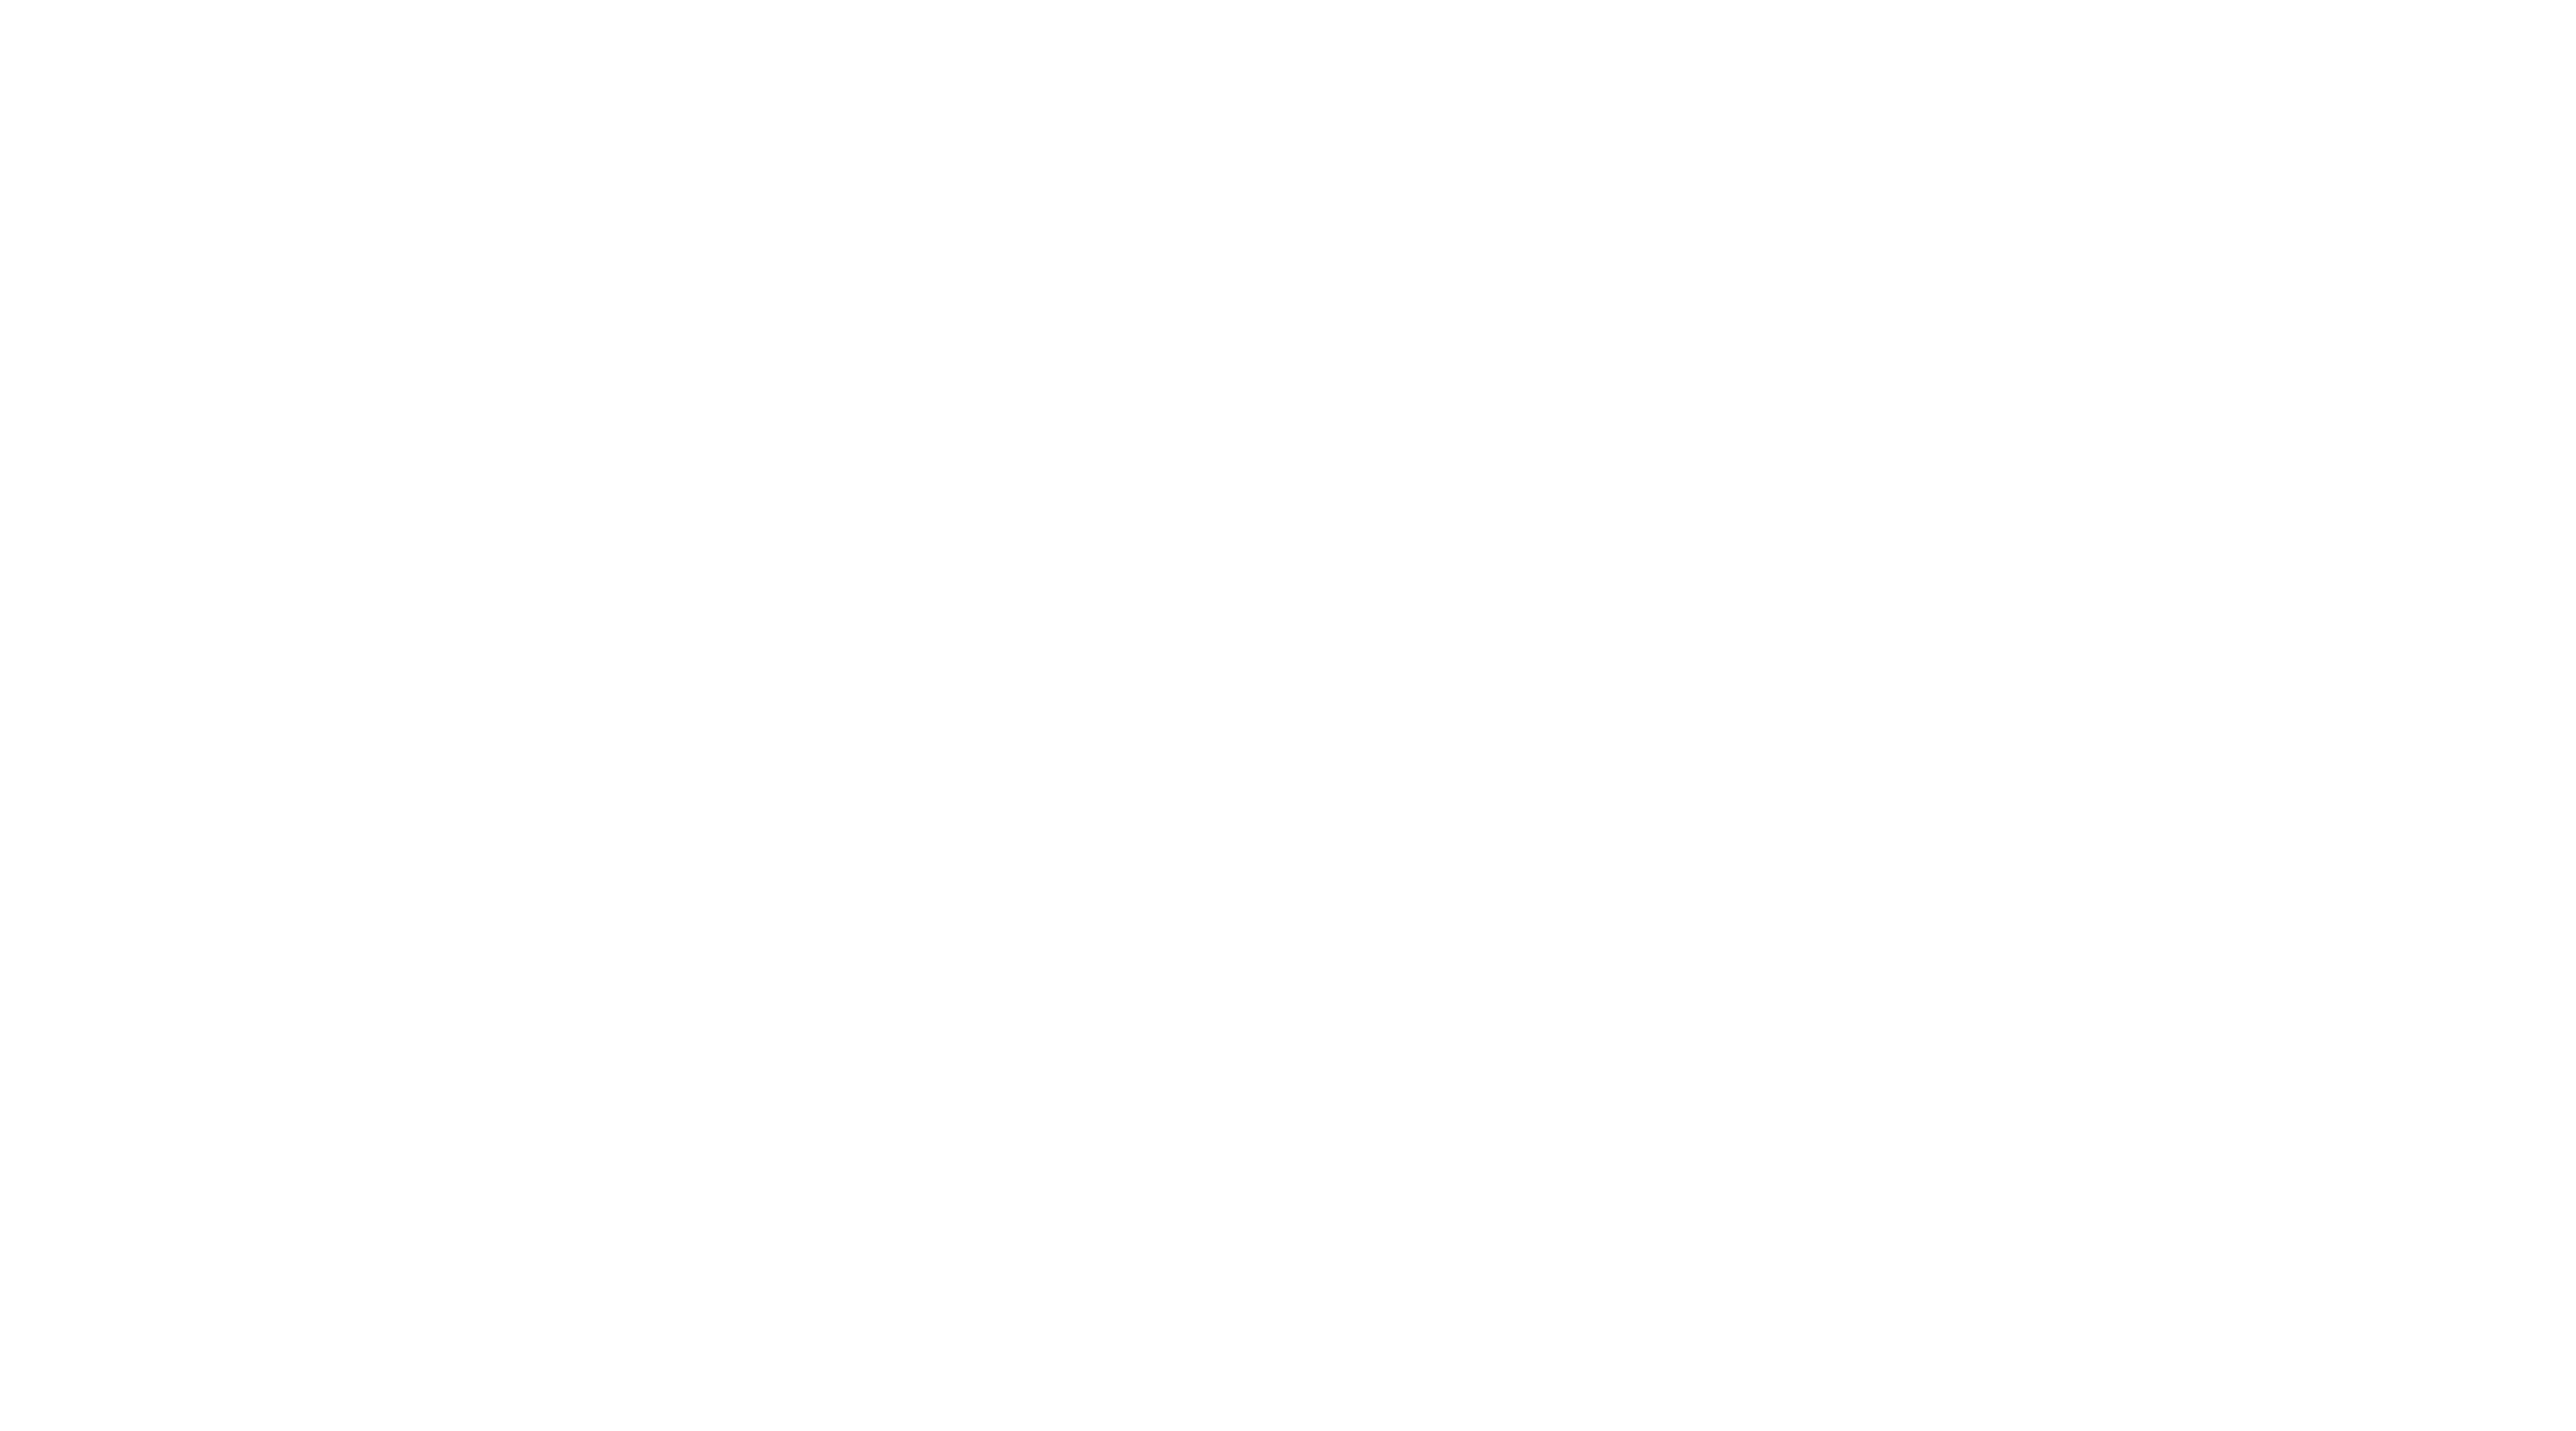

In [ ]:
#using CairoMakie
fig = Figure(size=(1800, 1000))

In [ ]:
# Animation setup
n = Observable(1)
b_slice = @lift interior(b_ts[$n], :, 1, :)
ζ_slice = @lift interior(ζ_ts[$n], :, 1, :)

u_slice = @lift interior(u_ts[$n], :, 1, :)
v_slice = @lift interior(v_ts[$n], :, 1, :)
w_slice = @lift interior(w_ts[$n], :, 1, :)

title_text = @lift "Day $(round(times[$n]/day, digits=1))"

Observable("Day 0.0")


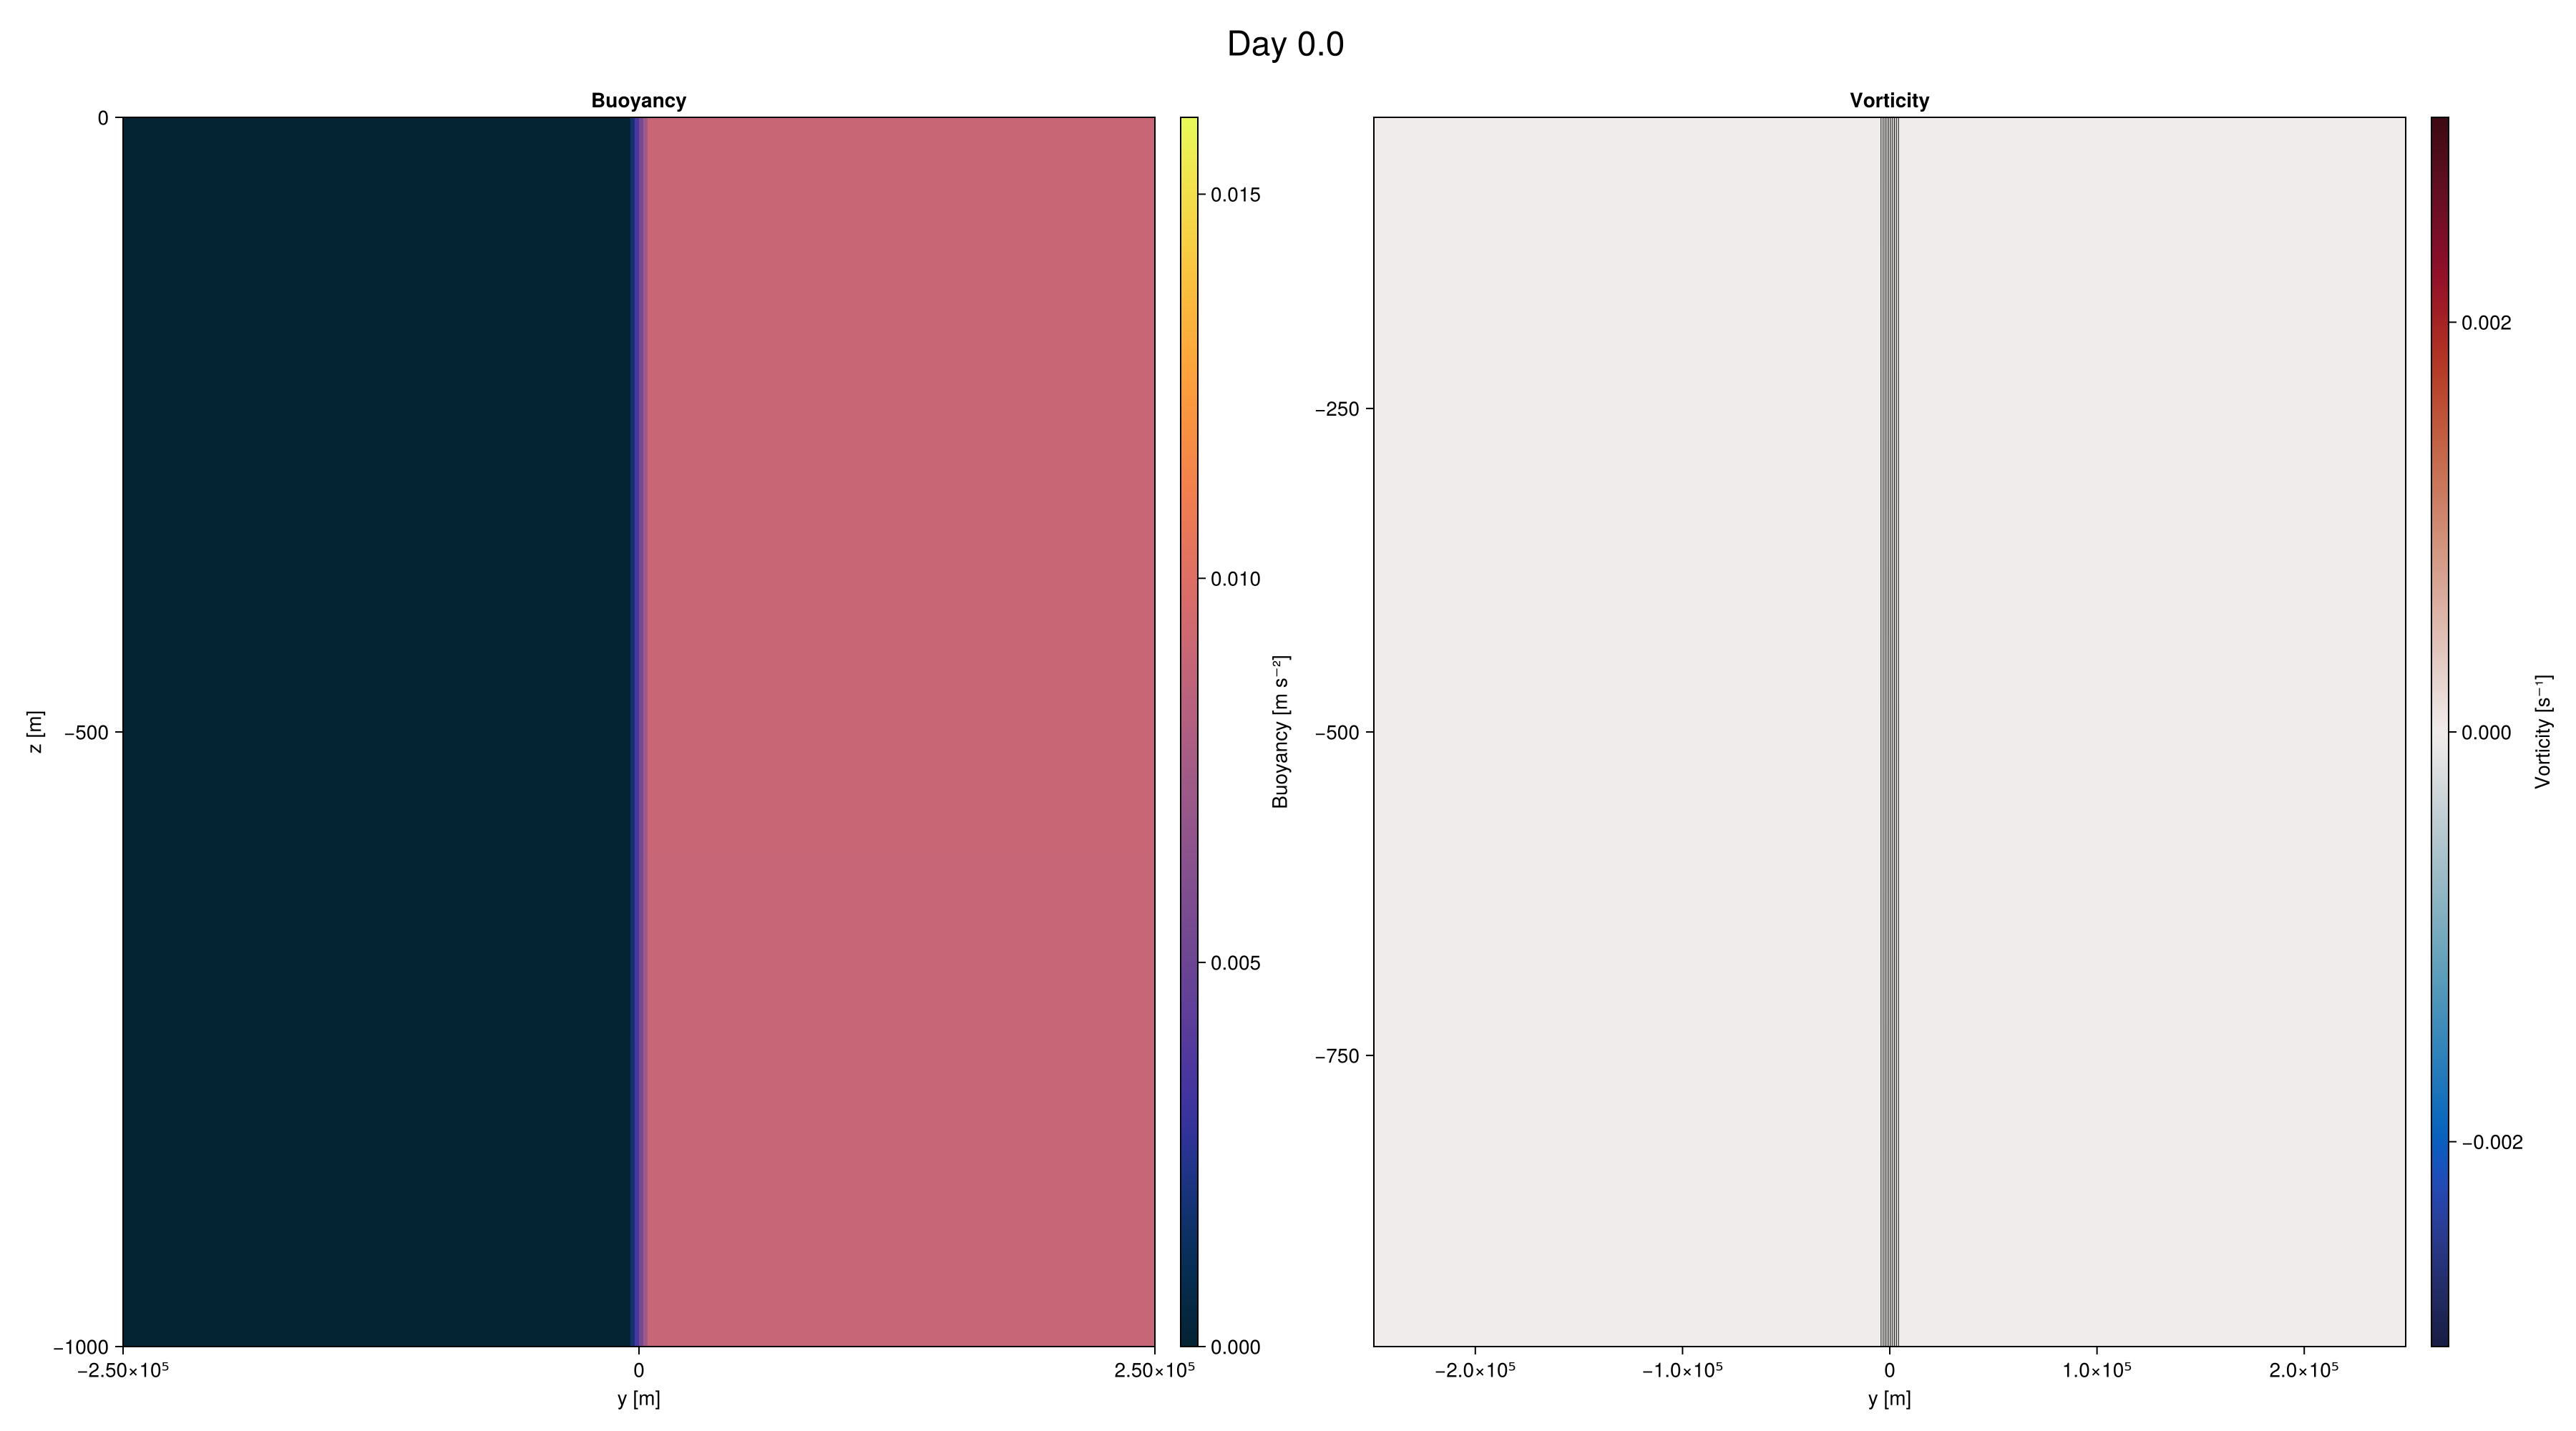

In [ ]:


# Animations of Buoyancy and Vorticity
empty!(fig)

# Buoyancy plot
ax_b = Axis(fig[1, 1], title="Buoyancy", xlabel="y [m]", ylabel="z [m]")
hm_b = heatmap!(ax_b, x, z, b_slice, colorrange=(0, Δb), colormap=:thermal)
Colorbar(fig[1, 2], hm_b, label="Buoyancy [m s⁻²]")
#(ax_b, x, z, b_slice ; levels=10, color=:black, linewidth=0.5)


# Vorticity plot
ax_ζ = Axis(fig[1, 3], title="Vorticity", xlabel="y [m]")
hm_ζ = heatmap!(ax_ζ, x, z, ζ_slice, colorrange=(-3e-3, 3e-3), colormap=:balance)
Colorbar(fig[1, 4], hm_ζ, label="Vorticity [s⁻¹]")
contour!(ax_ζ, x, z, b_slice ; levels=10, color=:black, linewidth=0.5)

Label(fig[0, :], title_text, fontsize=24)

# Create animation
frames = 1:length(times)
record(fig, filename * "_julia_animation.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame 


     



In [ ]:
#=

#animation of U only


empty!(fig)

ax_u = Axis(fig[1, 1], title="U", xlabel="y [m]", ylabel="z [m]")
hm = heatmap!(ax_u, x, z, u_slice; colorrange=(-5e-5, 5e-5), colormap=:balance)
Colorbar(fig[1, 2], hm_b, label="V [m s⁻1]")
contour!(ax_u, x, z, b_slice, levels=10, color=:black, linewidth=0.5)


# Create animation
frames = 1:length(times)
record(fig, filename * "_animation_velocities.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame

=#

In [ ]:
#animation of W only

#=

empty!(fig)

ax_w = Axis(fig[1, 1], title="W", xlabel="y [m]", ylabel="z [m]")
hm = heatmap!(ax_w, x, z, w_slice; colorrange=(-5e-5, 5e-5), colormap=:balance)
Colorbar(fig[1, 2], hm_b, label="W [m s⁻1]")
#contour!(ax_u, x, z, b_slice, levels=10, color=:black, linewidth=0.5)


# Create animation
frames = 1:length(times)
record(fig, filename * "_animation_velocities.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame

=#